In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy

# Custom modules
from model import *

In [3]:
# Load dataset
MNIST_TEST = datasets.MNIST(root='./../datasets', train=False, download=True, transform=transforms.ToTensor())
dataset0to4 = list(filter(lambda i: i[1] in [0, 1, 2, 3, 4], MNIST_TEST))
dataset5to9 = list(filter(lambda i: i[1] in [5, 6, 7, 8, 9], MNIST_TEST))
dataloader0to4 = DataLoader(dataset0to4, shuffle=True, batch_size=256)
dataloader5to9 = DataLoader(dataset5to9, shuffle=True, batch_size=256)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Training and Evaluation Code

In [4]:
SEED = 42

def train(model, dataloader, optimizer,
          criterion=None,
          num_epochs=5,
          ):
    model.train()
    if not criterion:
        criterion = torch.nn.CrossEntropyLoss()
    losses = []
    for epoch in tqdm(range(num_epochs), leave=True):
        train_loss = 0.0
        for batch in tqdm(dataloader, leave=False): 
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            loss_val = loss.detach().cpu().item()
            train_loss += loss_val / len(dataloader)
            losses.append(loss_val)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

    plt.plot(losses)
    plt.show()

In [5]:
def eval_model(model, dataloader):
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=-1)
            total += labels.shape[0]
            correct += (predictions == labels).sum().item()
        accuracy = correct / total

    print(f"{accuracy*100:.2f}%")

# Base Model

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/5 loss: 1.06


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/5 loss: 0.32


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/5 loss: 0.22


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4/5 loss: 0.18


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5/5 loss: 0.15


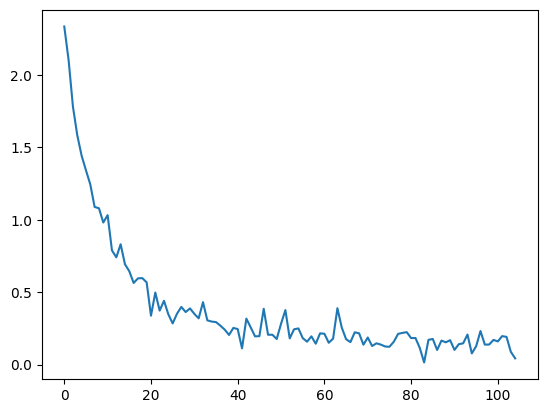

In [6]:
torch.manual_seed(SEED)
base_model = TheModel()
base_model.to(device)

optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)

train(base_model, dataloader0to4, optimizer)

In [7]:
eval_model(base_model, dataloader0to4)
eval_model(base_model, dataloader5to9)

96.50%
0.00%


# Full Finetuning

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/5 loss: 1.85


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/5 loss: 0.71


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/5 loss: 0.51


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4/5 loss: 0.38


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5/5 loss: 0.31


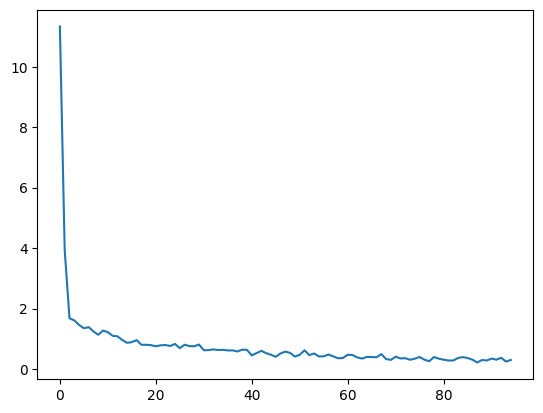

In [8]:
torch.manual_seed(SEED)
full_finetune_model = copy.deepcopy(base_model)
optimizer = torch.optim.Adam(full_finetune_model.parameters(), lr=0.001)

train(full_finetune_model, dataloader5to9, optimizer)

In [9]:
eval_model(full_finetune_model, dataloader0to4)
eval_model(full_finetune_model, dataloader5to9)

0.00%
91.40%


# Head-only Finetuning

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/5 loss: 3.27


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/5 loss: 0.86


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/5 loss: 0.73


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4/5 loss: 0.66


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5/5 loss: 0.60


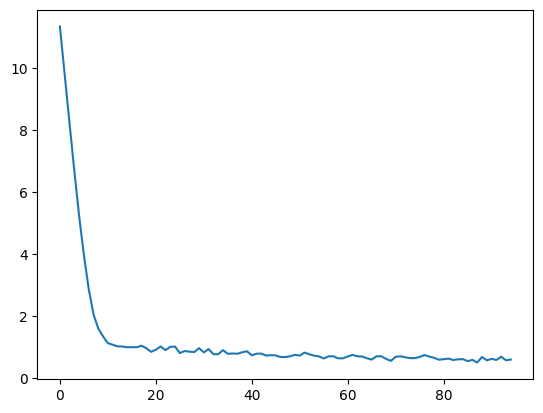

In [10]:
torch.manual_seed(SEED)
head_finetune_model = copy.deepcopy(base_model)
optimizer = torch.optim.Adam(head_finetune_model.mlp_head.parameters(), lr=0.001)

train(head_finetune_model, dataloader5to9, optimizer)

In [11]:
eval_model(head_finetune_model, dataloader0to4)
eval_model(head_finetune_model, dataloader5to9)

0.00%
80.46%


# Memory

Add learnable memory, fine tune head + memory.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/5 loss: 3.26


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/5 loss: 0.90


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/5 loss: 0.76


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4/5 loss: 0.68


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5/5 loss: 0.63


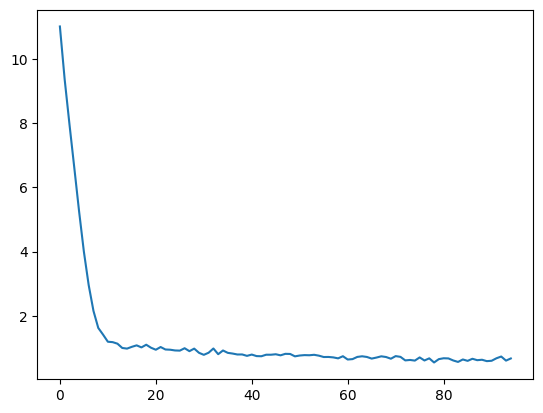

In [12]:
torch.manual_seed(SEED)
memory_finetune_model = copy.deepcopy(base_model)
memory_finetune_model.add_memory(2)

parameters = list(memory_finetune_model.mlp_head.parameters()) + memory_finetune_model.memory_parameters()
#parameters = memory_finetune_model.memory_parameters()
optimizer = torch.optim.Adam(parameters, lr=0.001)

train(memory_finetune_model, dataloader5to9, optimizer)

In [13]:
eval_model(memory_finetune_model, dataloader0to4)
eval_model(memory_finetune_model, dataloader5to9)

0.00%
80.62%


# Train from scratch with memory

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1/5 loss: 1.01


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/5 loss: 0.30


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/5 loss: 0.29


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4/5 loss: 0.19


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5/5 loss: 0.14


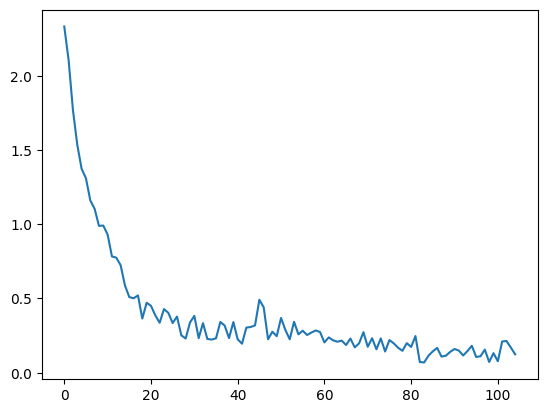

In [14]:
torch.manual_seed(SEED)
memory_model = TheModel()
memory_model.add_memory(2)
memory_model.to(device)
optimizer = torch.optim.Adam(memory_model.parameters(), lr=0.001)

train(memory_model, dataloader0to4, optimizer)

In [15]:
eval_model(memory_model, dataloader0to4)
eval_model(memory_model, dataloader5to9)

95.80%
0.00%
